In [1]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
df = pd.read_csv('WHO/ledata.csv')
df = df.dropna()

del df['Country']
del df['Year']
del df['Status']

y = df['Life expectancy '].to_numpy()

del df['Life expectancy ']

A = df.to_numpy()

n_train = 1349

A_train = A[:1349:]
y_train = y[:1349]

A_test = A[1349::]
y_test = y[1349:]

print(A_train.shape)

## data normalization 

mA = A_train.mean(axis=0)
sA = A_train.std(axis=0)


A_train = (A_train-mA)/sA
A_test = (A_test-mA)/sA

m = y_train.mean()
y_train = y_train-m
y_test = y_test-m

(1349, 18)


In [3]:
def score(X_n,A,y): #return the coeff of determination
    y_pred= A@X_n
    return 1-(((y_pred-y)**2).sum())/(((y-y.mean())**2).sum())

def loss(X_n,A,y):
    return np.mean(1/2*np.square(A@X_n-y))

In [4]:
### Gradient descent

def grad_desc(A,y,eps=1e-2,lr = None,lamb= 0,verbose=0,itemax=170):
    X = np.zeros(A.shape[1])
    grad = np.array([1000]*A.shape[1])
    if lr == None:
        lr = 1/np.linalg.norm(A,2)**2   

    l_loss = []
    ite = 0
    while np.all(np.abs(grad) > eps) and ite<itemax:
        y_pred = A.dot(X)
        grad = np.dot(A.T,(y_pred-y))+2*lamb*X
        X = X - lr*grad 
        l_loss.append((1/2*(y_pred-y)**2+lamb*np.sum(np.square(X))).mean())
        ite+=1

    if verbose == 1:
        plt.figure(1)
        plt.plot(l_loss)
        plt.show()
        
    return X,l_loss


Randomized Block Coordinate Descent

In [14]:
def RBCD(A,y,eps=1e-5,lr = None,verbose=0,itemax=17000,batch_size=1):
    X = np.zeros(A.shape[1])
    grad = np.array([1000]*A.shape[1])

    if lr == None:
        lr = 1/np.linalg.norm(A,2)**2   

    l_loss = []
    ite = 0
    m_l = 0
    l_i = np.arange(len(X))
    while np.all(np.abs(grad) > eps) and ite<itemax:

        y_pred = A.dot(X)
        grad = np.dot(A.T,(y_pred-y))

        if len(l_i)<=batch_size:
            batch = l_i
            l_i = np.arange(len(X))
        else:
            np.random.shuffle(l_i)
            batch = l_i[:batch_size]
            l_i = l_i[batch_size:]

        e = np.zeros_like(grad)
        e[batch]=grad[batch]
        X =X -lr*e
        
        l_loss.append((1/2*(y_pred-y)**2).mean())
        ite+=1      
        

    if verbose == 1:
        plt.figure(1)
        plt.plot(l_loss)
        plt.xlabel('iteration')
        plt.ylabel('loss')
        plt.show()
        
    return X,l_loss

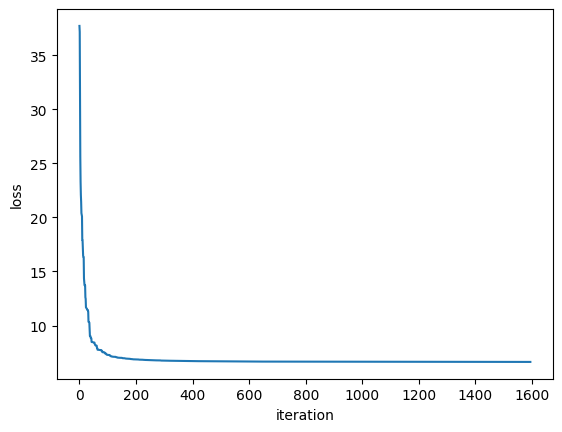

8.135225282542873


In [34]:
X,l_loss = RBCD(A_train,y_train,eps=1e-3,verbose=1,batch_size=1)
print(loss(X,A_test,y_test))

100%|██████████| 17/17 [01:48<00:00,  6.41s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


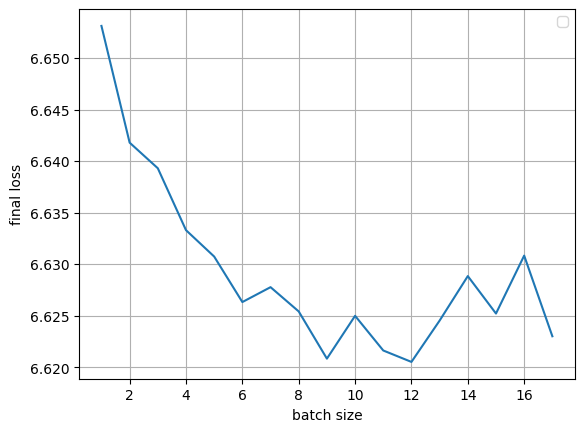

In [58]:
L_loss =[]

l_i = list(range(1,18))
for i in tqdm(l_i):
    mean = 0
    for k in range(100):
        X_n,l_loss = RBCD(A_train,y_train,eps=1e-3,batch_size=i)
        mean+=loss(X_n,A_test,y_test)
    L_loss.append(mean/100)


plt.figure(1)
plt.plot(l_i,L_loss)
plt.xlabel('batch size')
plt.ylabel('final loss')
plt.xlim()
plt.ylim()
plt.grid()
plt.legend()
plt.show()

RBCD combined with SGD

In [43]:
def RBCSGD(A,y,eps=1e-5,lr = None,verbose=0,itemax=20000,batch_size_c=1,batch_size_s=1):
    X = np.zeros(A.shape[1])
    grad = np.array([1000]*A.shape[1])

    if lr == None:
        lr = 1/np.linalg.norm(A,2)**2   

    l_loss = []
    ite = 0
    m_l = 0
    l_i = np.arange(len(X))
    l_j = np.arange(len(y))
    m_l = 0
    while np.all(np.abs(grad) > eps) and ite<itemax:
        np.random.shuffle(l_j)

        for batch_start in range(0,len(y),batch_size_s):
            batch_end =batch_start+batch_size_s
            j = l_j[batch_start:batch_end]

            y_pred = A[i,:].dot(X)           
            grad =  np.dot(A[i,:].T,(y_pred-y[i]))

            if len(l_i)<=batch_size_c:
                batch = l_i
                l_i = np.arange(len(X))
            else:
                np.random.shuffle(l_i)
                batch = l_i[:batch_size_c]
                l_i = l_i[batch_size_c:]

            e = np.zeros_like(grad)
            e[batch]=grad[batch]
            X =X -lr*e
            
            m_l*=ite
            m_l+= (1/2*(y_pred-y[i])**2).mean()
            m_l/=(ite+1)
            l_loss.append(m_l)
            ite+=1     
        

    if verbose == 1:
        plt.figure(1)
        plt.plot(l_loss)
        plt.xlabel('iteration')
        plt.ylabel('loss')
        plt.show()
        
    return X,l_loss

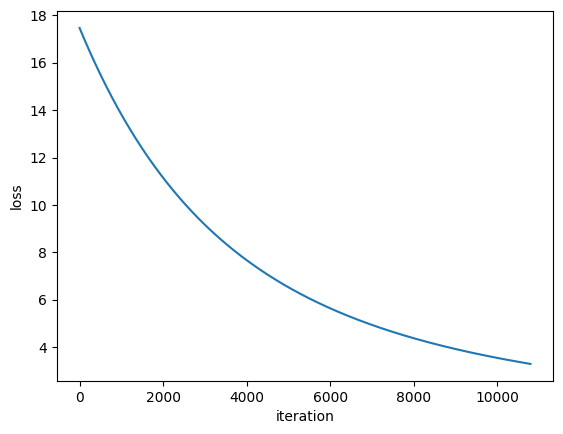

20.6022168542698


In [53]:
X,l_loss = RBCSGD(A_train,y_train,eps=1e-3,verbose=1,batch_size_c=10,batch_size_s=1)
print(loss(X,A_test,y_test))

In [ ]:
L_loss =[]

l_i = list(range(1))
for i in tqdm(l_i):
    mean = 0
    for k in range(20):
        X_n,l_loss = RBCSGD(A_train,y_train,eps=1e-3,batch_size_c=i,btach_size_s=10)
        mean+=loss(X_n,A_test,y_test)
    L_loss.append(mean/20)


plt.figure(1)
plt.plot(l_i,L_loss)
plt.xlabel('batch size')
plt.ylabel('final loss')
plt.xlim()
plt.ylim()
plt.grid()
plt.legend()
plt.show()